In [10]:
import pandas as pd
import numpy as np

df = pd.read_parquet('../data/cleaned_data.parquet')

In [11]:
df['margin_rate'] = (df['seller_price'] - df['seller_earning']) / df['seller_price']
df.drop(columns=['product_color', 'product_id'], inplace=True)
df.drop(columns=['product_category_encoded','has_cross_border_fees_encoded'], inplace=True)

df1 = df
# Create Derived Features
df1['price_to_earning_ratio'] = df1['price_usd'] / (df1['seller_earning'] + 1)  # Avoid division by zero
df1['price_per_like'] = df1['price_usd'] / (df1['product_like_count'] + 1)      # Avoid division by zero
df1['seller_activity_ratio'] = df1['seller_products_sold'] / (df1['seller_num_products_listed'] + 1)  # Avoid division by zero


2025/04/29 00:54:34 WARNING mlflow.xgboost: Failed to log dataset information to MLflow Tracking. Reason: The following failures occurred while performing one or more logging operations: [MlflowException("Failed to perform one or more operations on the run with ID 93bc298099e94aa3942719ee2f7ab290. Failed operations: [FileNotFoundError(2, 'No such file or directory')]")]
2025/04/29 00:54:34 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "c:\Users\abmir\AppData\Local\pypoetry\Cache\virtualenvs\ml-workflow-88owM936-py3.11\Lib\site-packages\mlflow\xgboost\__init__.py", line 738, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "c:\Users\abmir\AppData\Local\pypoetry\Cache\virtualenvs\ml-workflow-88owM936-py3.11\Lib\site-packages\mlflow\xgboost\__init__.py", line 637, in log_feature_importance_plot
    mlflow.log_artifact(filepath)


XGBoost Validation ROC-AUC: 0.8566 | Time: 0.14 min


MissingConfigException: Yaml file '..\mlruns\732189633993811001\93bc298099e94aa3942719ee2f7ab290\inputs\0a2bfa86999aa09931c724ecaf72b795\meta.yaml' does not exist.

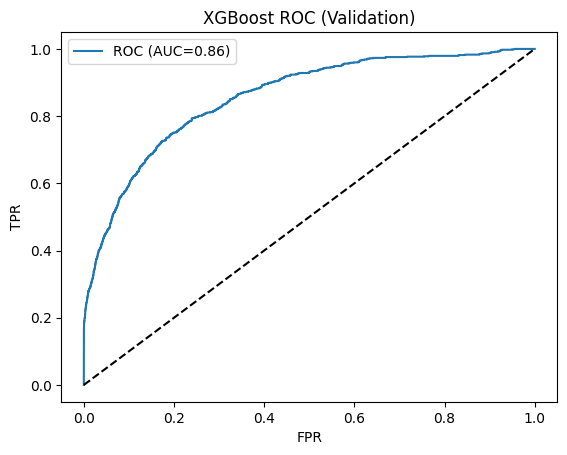

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, log_loss, roc_curve, precision_recall_curve
)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import time
import tempfile
import os

# Set MLflow experiment to save logs in default './mlruns/' folder
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Vestiaire_Model_Comparison")
if mlflow.active_run():
    mlflow.end_run()

# Filter dataset to the most important features
important_features = [
    'seller_price', 'seller_badge_encoded', 'should_be_gone', 'seller_pass_rate',
    'price_to_earning_ratio', 'seller_products_sold', 'price_per_like', 'brand_id',
    'product_type', 'product_material', 'product_like_count', 'seller_num_products_listed',
    'seller_community_rank', 'seller_activity_ratio', 'product_color_encoded',
    'seller_num_followers', 'margin_rate', 'available', 'seller_country', 'in_stock',
    'product_season_encoded', 'usually_ships_within_encoded', 'product_condition_encoded',
    'warehouse_name_encoded'
]

# Assuming your DataFrame is named 'df1'
X = df1[important_features]
y = df1['sold']

# Use a sample of the dataset for faster experimentation (30% of data)
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=0.3, random_state=42, stratify=y
)

# Split sample into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sample, y_sample, test_size=0.4, random_state=42, stratify=y_sample
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

def train_and_evaluate_with_mlflow(model, model_name, X_train, y_train, X_val, y_val, parent_run_id=None):
    with mlflow.start_run(run_name=model_name, nested=True, parent_run_id=parent_run_id):
        start_time = time.time()

        # Train the model on the training set
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

        # Calculate metrics on validation set
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        logloss = log_loss(y_val, y_pred_prob)

        elapsed_time = (time.time() - start_time) / 60
        print(f"{model_name} Validation ROC-AUC: {roc_auc:.4f} | Time: {elapsed_time:.2f} min")

        # Log parameters and validation metrics
        mlflow.log_params(model.get_params())
        mlflow.log_metrics({
            "roc_auc": roc_auc,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "log_loss": logloss
        })

        # Log curves as artifacts
        temp_dir = tempfile.mkdtemp()
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        plt.figure(); plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.2f})"); plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f"{model_name} ROC (Validation)"); plt.legend()
        roc_path = os.path.join(temp_dir, f"{model_name}_validation_roc.png")
        plt.savefig(roc_path); mlflow.log_artifact(roc_path); plt.close()

        precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_prob)
        plt.figure(); plt.plot(recall_vals, precision_vals, label="PR Curve"); plt.xlabel('Recall'); plt.ylabel('Precision');
        plt.title(f"{model_name} PR (Validation)"); plt.legend()
        prc_path = os.path.join(temp_dir, f"{model_name}_validation_prc.png")
        plt.savefig(prc_path); mlflow.log_artifact(prc_path); plt.close()

        return model


def plot_learning_curve_and_log(model, X_train, y_train, model_name):
    start_time = time.time()
    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1,
        train_sizes=np.linspace(0.1, 0.5, 3)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label=f"{model_name} Train")
    plt.plot(train_sizes, test_mean, label=f"{model_name} Validation")
    plt.title(f"{model_name} Learning Curve")
    plt.xlabel("Training Size"); plt.ylabel("ROC-AUC Score"); plt.legend(); plt.grid()

    temp_dir = tempfile.mkdtemp()
    plot_path = os.path.join(temp_dir, f"{model_name}_learning_curve.png")
    plt.savefig(plot_path); mlflow.log_artifact(plot_path); plt.close()

    elapsed_time = (time.time() - start_time) / 60
    print(f"{model_name} Learning Curve completed in {elapsed_time:.2f} min")

# Initialize models
xgb_model = xgb.XGBClassifier(eval_metric='auc', random_state=42, n_estimators=30, max_depth=3, tree_method='hist', n_jobs=-1)

lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=30, max_depth=3, device='cpu')

cat_model = cb.CatBoostClassifier(verbose=0, random_state=42, iterations=30, depth=3, task_type='CPU')

# Parent run to group all child runs
with mlflow.start_run(run_name="Model Comparison") as parent_run:
    parent_run_id = parent_run.info.run_id

    # Validation experiments
    xgb_model = train_and_evaluate_with_mlflow(xgb_model, "XGBoost", X_train, y_train, X_val, y_val, parent_run_id)
    plot_learning_curve_and_log(xgb_model, X_train, y_train, "XGBoost")

    lgb_model = train_and_evaluate_with_mlflow(lgb_model, "LightGBM", X_train, y_train, X_val, y_val, parent_run_id)
    plot_learning_curve_and_log(lgb_model, X_train, y_train, "LightGBM")

    cat_model = train_and_evaluate_with_mlflow(cat_model, "CatBoost", X_train, y_train, X_val, y_val, parent_run_id)
    plot_learning_curve_and_log(cat_model, X_train, y_train, "CatBoost")

    # Final evaluation on the held-out test set
    with mlflow.start_run(run_name="Test_Evaluation", nested=True, parent_run_id=parent_run_id):
        print("\nLogging Final Performance on Test Set to MLflow:")
        for model, model_name in [(xgb_model, "XGBoost"), (lgb_model, "LightGBM"), (cat_model, "CatBoost")]:
            y_test_pred_prob = model.predict_proba(X_test)[:, 1]
            y_test_pred = model.predict(X_test)

            metrics = {
                f"{model_name}_test_roc_auc": roc_auc_score(y_test, y_test_pred_prob),
                f"{model_name}_test_accuracy": accuracy_score(y_test, y_test_pred),
                f"{model_name}_test_precision": precision_score(y_test, y_test_pred),
                f"{model_name}_test_recall": recall_score(y_test, y_test_pred),
                f"{model_name}_test_f1": f1_score(y_test, y_test_pred),
                f"{model_name}_test_log_loss": log_loss(y_test, y_test_pred_prob)
            }
            print(metrics)
            mlflow.log_metrics(metrics)

            # Log test ROC and PR curves
            temp_dir = tempfile.mkdtemp()
            fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
            plt.figure(); plt.plot(fpr, tpr, label=f"ROC (AUC={metrics[f'{model_name}_test_roc_auc']:.2f})"); plt.plot([0,1],[0,1],'k--')
            plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f"{model_name} ROC (Test)"); plt.legend()
            roc_path = os.path.join(temp_dir, f"{model_name}_test_roc.png")
            plt.savefig(roc_path); mlflow.log_artifact(roc_path); plt.close()

            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_pred_prob)
            plt.figure(); plt.plot(recall_vals, precision_vals, label="PR Curve"); plt.xlabel('Recall'); plt.ylabel('Precision');
            plt.title(f"{model_name} PR (Test)"); plt.legend()
            prc_path = os.path.join(temp_dir, f"{model_name}_test_prc.png")
            plt.savefig(prc_path); mlflow.log_artifact(prc_path); plt.close()
